# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. We filter the single cells by identifying outliers with z-scores, and use either combinations of features or one feature for each condition. We use features from the AreaShape and Intensity modules to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence with various seeding densities, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. 
To identify these nuclei, we use:

- **Nuclei mass displacement:** This metric quantifies how different the segmentation versus intensity based centeroids are, which can reflect multiple nuclei within one segmentation. 
- **Nuclei intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. 
In combination with abnormally high mass displacement, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

For the preliminary dataset, we are working with cells that have not been treated so we do not expect any crazy phenotypes. Given that context, we can use a feature called Solidity. From ChatGPT, the simple explanation is that this features compares the area of the object to its convex hull, which measures compactness in relation to convexity. High solidity implies few indentations, while lower solidity indicates more irregularity.

- **Nuclei solidity:** This metric quantifies the compactness of the nuclei shape.
When a nuclei is mis-segmented, we see more protrusions or harsh outlines around the segmentations, which we expect this is what this feature will detect.

### Assessing poor cell segmentation

Also due to high confluence, overlapping nuclei can lead to the CellProfiler segmentation algorithm to sometimes keep bad segmentations (which is why we have coSMicQC) but can also detect these segmentations as being "too large" based on the parameters. 
This leads to poor cell segmentations because CellProfiler will remove the context of the nuclei it couldn't segment, leading to segmenting multiple cells as one cell and assigning it to one nuclei.
To identify these cells, we use:

- **Cell intensity in the nuclei channel:** This metric quantifies the total intensity of all pixels of a cell segmentation in the nuclei channel. We would expect fairly low total intensity in the nuclei channel for whole cells as there is only one 



In [1]:
import dask.dataframe as dd
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

from cytodataframe import CytoDataFrame
from cosmicqc import find_outliers

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_59539/3846214131.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask config set dataframe.query-pla

In [2]:
data_dir = pathlib.Path("./data/converted_profiles")

# Load only the required columns from all converted profiles
all_profiles = []
for file in data_dir.glob("*_converted.parquet"):
    df = dd.read_parquet(
        file,
        engine="pyarrow",
        columns=["Image_Metadata_Plate", "Nuclei_AreaShape_FormFactor"],
    ).compute()
    all_profiles.append(df)

# Concatenate all profiles
all_profiles_df = pd.concat(all_profiles, ignore_index=True)

# Calculate the mean of Nuclei_AreaShape_FormFactor per Metadata_Plate
mean_form_factor = all_profiles_df.groupby("Image_Metadata_Plate")[
    "Nuclei_AreaShape_FormFactor"
].mean()

# Display the result
print(mean_form_factor)

Image_Metadata_Plate
BR00143976    0.851128
BR00143977    0.854945
BR00143978    0.847024
BR00143979    0.844024
BR00143980    0.838464
BR00143981    0.837461
Name: Nuclei_AreaShape_FormFactor, dtype: float64


# Set functions for plotting

### Function to plot scatterplot

In [2]:
def plot_cluster_nuclei_outliers(
    plate_df: pd.DataFrame,
    outliers_df: pd.DataFrame,
    plate_name: str,
    qc_fig_dir: pathlib.Path,
) -> None:
    """Plot scatterplot of the cluster nuclei outliers.

    Args:
        plate_df (pd.DataFrame): Dataframe of the CytoTable output with the morphology profiles.
        outliers_df (pd.DataFrame): Dataframe of the coSMicQC output which includes the identified outliers.
        plate_name (str): String of the plate's name or ID.
        qc_fig_dir (pathlib.Path): Path to the directory to save the plot.
    """
    # Create a copy of plate_df to avoid modifying the original
    plate_df = plate_df.copy()

    # Set the default 'Outlier_Status' to 'Single-cell passed QC'
    plate_df["Outlier_Status"] = "Single-cell passed QC"

    # Update 'Outlier_Status' for cells that failed QC
    plate_df.loc[plate_df.index.isin(outliers_df.index), "Outlier_Status"] = (
        "Single-cell failed QC"
    )

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=plate_df,
        x="Nuclei_Intensity_MassDisplacement_CorrDNA",
        y="Nuclei_Intensity_IntegratedIntensity_CorrDNA",
        hue="Outlier_Status",
        palette={
            "Single-cell passed QC": "#006400",
            "Single-cell failed QC": "#990090",
        },
        alpha=0.2,
    )

    # Add threshold lines
    plt.axvline(
        x=outliers_df["Nuclei_Intensity_MassDisplacement_CorrDNA"].min(),
        color="r",
        linestyle="--",
        label="Min. threshold for Nuclei Mass Displacement",
    )
    plt.axhline(
        y=outliers_df["Nuclei_Intensity_IntegratedIntensity_CorrDNA"].min(),
        color="b",
        linestyle="--",
        label="Min. threshold for Nuclei Intensity",
    )

    # Customize plot
    plt.title(f"Nuclei Mass Displacement vs. Nuclei Integrated Intensity for plate {plate_name}")
    plt.xlabel("Nuclei Mass Displacement (Hoechst)")
    plt.ylabel("Nuclei Integrated Intensity (Hoechst)")
    plt.tight_layout()

    # Show legend
    plt.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0), prop={"size": 10})

    # Save figure without showing it
    plt.savefig(
        pathlib.Path(f"{qc_fig_dir}/{plate_name}_cluster_nuclei_outliers.png"), dpi=500
    )
    plt.close()  # Close the plot to prevent it from displaying

### Function to plot KDE

In [3]:
def plot_nuclei_solidity_histogram(
    plate_df: pd.DataFrame,
    outliers_df: pd.DataFrame,
    plate_name: str,
    qc_fig_dir: pathlib.Path,
) -> None:
    """Plot histogram of the nuclei solidity outliers.

    Args:
        plate_df (pd.DataFrame): Dataframe of the CytoTable output with the morphology profiles.
        outliers_df (pd.DataFrame): Dataframe of the coSMicQC output which includes the identified outliers.
        plate_name (str): String of the plate's name or ID.
        qc_fig_dir (pathlib.Path): Path to the directory to save the plot.
    """
    # Create a copy of plate_df to avoid modifying the original
    plate_df = plate_df.copy()

    # Set the default 'Outlier_Status' to 'Single-cell passed QC'
    plate_df["Outlier_Status"] = "Single-cell passed QC"

    # Update 'Outlier_Status' for cells that failed QC
    plate_df.loc[plate_df.index.isin(outliers_df.index), "Outlier_Status"] = (
        "Single-cell failed QC"
    )

    # Create histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=plate_df,
        x="Nuclei_AreaShape_Solidity",
        hue="Outlier_Status",
        palette={
            "Single-cell passed QC": "#006400",
            "Single-cell failed QC": "#990090",
        },
        multiple="stack",  # Stacks bars based on hue
        bins=50,  # Number of bins
        kde=False,
    )

    # Add threshold line
    max_threshold = outliers_df["Nuclei_AreaShape_Solidity"].max()
    plt.axvline(
        x=max_threshold,
        color="r",
        linestyle="--",
        label=f"Threshold for Outliers: < {max_threshold}",
    )

    # Customize plot
    plt.ylabel("Count")
    plt.xlabel("Nuclei Solidity")
    plt.title(f"Distribution of Nuclei Solidity for plate {plate_name}")
    plt.legend()
    plt.tight_layout()

    # Save figure without showing it
    plt.savefig(
        pathlib.Path(
            f"{qc_fig_dir}/{plate_name}_nuclei_solidity_outliers_histogram.png"
        ),
        dpi=500,
    )
    plt.close()  # Close the plot to prevent it from displaying

## Set paths and variables

In [4]:
# Set parameter for papermill to use for processing
plate_id = "BR00143976"

In [5]:
# Parameters
plate_id = "BR00143978"


## Injected parameter from papermill that updates for every plate being processed

In [6]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Directory to save qc results
qc_results_dir = pathlib.Path("./qc_results")
qc_results_dir.mkdir(exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# Set the compartment of choice to perform QC at the start (will change later)
compartment = "Nuclei"

## Load in plate to perform QC on

In [7]:
# Construct the file path for the given plate_id
file_path = data_dir / f"{plate_id}_converted.parquet"

if file_path.exists():
    start_time = time.time()  # Start timer for loading

    # Load and compute the DataFrame
    plate_df = dd.read_parquet(file_path, engine="pyarrow").compute()

    end_time = time.time()  # End timer for loading
    print(
        f"Loaded plate: {plate_id}, Shape: {plate_df.shape}, Time taken: {end_time - start_time:.2f} seconds"
    )
else:
    print(f"Parquet file for plate {plate_id} not found.")

Loaded plate: BR00143978, Shape: (465740, 3035), Time taken: 87.19 seconds


## Set columns and mapping

In [8]:
# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    f"Metadata_{compartment}_Location_Center_X",
    f"Metadata_{compartment}_Location_Center_Y",
    "Image_FileName_OrigDNA",
    "Image_FileName_OrigAGP",
    "Image_PathName_OrigDNA",
    "Image_PathName_OrigAGP",
    f"{compartment}_AreaShape_BoundingBoxMaximum_X",
    f"{compartment}_AreaShape_BoundingBoxMaximum_Y",
    f"{compartment}_AreaShape_BoundingBoxMinimum_X",
    f"{compartment}_AreaShape_BoundingBoxMinimum_Y",
]

# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {
    rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff": 
    rf"r{int(record['Image_Metadata_Row']):02d}c{int(record['Image_Metadata_Col']):02d}f{int(record['Image_Metadata_Site']):02d}p(\d{{2}})-ch\d+sk\d+fk\d+fl\d+\.tiff"
    for record in plate_df[
        [
            "Image_Metadata_Plate",
            "Image_Metadata_Well",
            "Image_Metadata_Site",
            "Image_Metadata_Row",
            "Image_Metadata_Col",
        ]
    ].to_dict(orient="records")
}
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('NucleiOutlines_BR00143978_J16_7.tiff',
 'r10c16f07p(\\d{2})-ch\\d+sk\\d+fk\\d+fl\\d+\\.tiff')

## Filter down plate data to detect nuclei outliers (improves speed)

In [9]:
# Define the QC features
qc_features = [
    "Nuclei_Intensity_IntegratedIntensity_CorrDNA",
    "Nuclei_AreaShape_Solidity",
    "Nuclei_Intensity_MassDisplacement_CorrDNA",
]

# Filter plate_df to only include metadata columns and QC features
filtered_plate_df = plate_df[metadata_columns + qc_features]

## Detect segmentations of clustered nuclei

Number of outliers: 18593 (3.99%)
Outliers Range:
Nuclei_Intensity_MassDisplacement_CorrDNA Min: 0.5560302293666787
Nuclei_Intensity_MassDisplacement_CorrDNA Max: 16.391380798829957
Nuclei_Intensity_IntegratedIntensity_CorrDNA Min: 183.01864505559206
Nuclei_Intensity_IntegratedIntensity_CorrDNA Max: 1358.7651822939515
(18593, 3)


,Nuclei_Intensity_MassDisplacement_CorrDNA,Nuclei_Intensity_IntegratedIntensity_CorrDNA,Image_FileName_OrigDNA
96650,0.556030,297.408236,
42214,0.556122,208.023985,

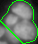
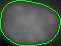

In [10]:
# Find large nuclei outliers for the current plate
nuclei_clustered_outliers = find_outliers(
    df=filtered_plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "Nuclei_Intensity_MassDisplacement_CorrDNA": 0.05, # Set very low as to detect all instances of clustering nuclei
        "Nuclei_Intensity_IntegratedIntensity_CorrDNA": 1.5, # Set higher than displacement to avoid false positives
    },
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
nuclei_clustered_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(nuclei_clustered_outliers),
    data_outline_context_dir=f"../2.feature_extraction/sqlite_outputs/{plate_id}/outlines",
    segmentation_file_regex=outline_to_orig_mapping,
)[
    [
        "Nuclei_Intensity_MassDisplacement_CorrDNA",
        "Nuclei_Intensity_IntegratedIntensity_CorrDNA",
        "Image_FileName_OrigDNA",
    ]
]


print(nuclei_clustered_outliers_cdf.shape)
nuclei_clustered_outliers_cdf.sort_values(
    by="Nuclei_Intensity_MassDisplacement_CorrDNA", ascending=True
).head(2)

,Nuclei_Intensity_MassDisplacement_CorrDNA,Nuclei_Intensity_IntegratedIntensity_CorrDNA,Image_FileName_OrigDNA
28086,4.211066,280.276529,
90144,2.288558,208.026360,

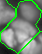
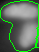

In [11]:
nuclei_clustered_outliers_cdf.sample(n=2, random_state=0)

### Plot the outliers

In [12]:
# Save cluster nuclei scatterplot
plot_cluster_nuclei_outliers(
    plate_df=plate_df,
    outliers_df=nuclei_clustered_outliers_cdf,
    plate_name=plate_id,
    qc_fig_dir=qc_fig_dir,
)

## Detect very irregular shaped nuclei, likely indicating mis-segmentation

**NOTE:** For the pilot data, we are determining optimal conditions (seeding density and time point). This means all cells are not treated and should be in a "healthy" state. Given that `solidity` measures how irregular the shape of a nuclei is, we would expect that cells treated with a drug/compound could yield interesting shapes or phenotypes. Since we are not working with drug treatments at this time, we can use this feature to identify technically incorrect segmentations.

Number of outliers: 34536 (7.42%)
Outliers Range:
Nuclei_AreaShape_Solidity Min: 0.4885439763488544
Nuclei_AreaShape_Solidity Max: 0.9071942446043165


(34536, 2)


,Nuclei_AreaShape_Solidity,Image_FileName_OrigDNA
147956,0.907194,
118551,0.907194,

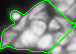
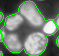

In [13]:
# Find low nuclei solidity outliers for the current plate
solidity_nuclei_outliers = find_outliers(
    df=filtered_plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "Nuclei_AreaShape_Solidity": -1.6, # Set at this point where it looks like it starts to detect good quality nuclei
    },
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
solidity_nuclei_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(solidity_nuclei_outliers),
    data_outline_context_dir=f"../2.feature_extraction/sqlite_outputs/{plate_id}/outlines",
    segmentation_file_regex=outline_to_orig_mapping,
)[
    [
        "Nuclei_AreaShape_Solidity",
        "Image_FileName_OrigDNA",
    ]
]


print(solidity_nuclei_outliers_cdf.shape)
solidity_nuclei_outliers_cdf.sort_values(
    by="Nuclei_AreaShape_Solidity", ascending=False
).head(2)

In [14]:
solidity_nuclei_outliers_cdf.sample(n=2, random_state=0)

,Nuclei_AreaShape_Solidity,Image_FileName_OrigDNA
16065,0.889362,
196682,0.894118,


### Plot the outliers

In [15]:
# Save low nuclei solidity histogram
plot_nuclei_solidity_histogram(
    plate_df=plate_df,
    outliers_df=solidity_nuclei_outliers,
    plate_name=plate_id,
    qc_fig_dir=qc_fig_dir,
)

## Detect cells that contain multiple nuclei due to segmentation issues

When CellProfiler segments a cluster of nuclei and decides that it is over the diameter range as specified in the parameters, it will not include that segmentation when segmenting whole cells. 
This can lead to a whole cell segmentation based on one nuclei including the adjacent nuclei that was not included as a segmentation.

This description requires prior knowledge of the `IdentifyPrimaryObjects` and `IdentifySecondaryObjects` modules.

As a metaphor, we can think of it as three apples on a plate.
One apple is detected correctly as one apple, but the other two were two close together, detected as one apple, and then removed from the plate because of it.
Now, it looks like the whole plate belongs to the one correct apple, but in reality the plate should be split between three apples.
This is the problem we want to avoid for a single-cell segmentation, we don't want to have a whole cell segmentation be assigned to one nuclei when it actually contains multiple nuclei.


In [16]:
# change compartment to cells
compartment = "Cells"

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    f"Metadata_{compartment}_Location_Center_X",
    f"Metadata_{compartment}_Location_Center_Y",
    "Image_FileName_OrigDNA",
    "Image_FileName_OrigAGP",
    "Image_PathName_OrigDNA",
    "Image_PathName_OrigAGP",
    f"{compartment}_AreaShape_BoundingBoxMaximum_X",
    f"{compartment}_AreaShape_BoundingBoxMaximum_Y",
    f"{compartment}_AreaShape_BoundingBoxMinimum_X",
    f"{compartment}_AreaShape_BoundingBoxMinimum_Y",
]

# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {
    rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff": 
    rf"r{int(record['Image_Metadata_Row']):02d}c{int(record['Image_Metadata_Col']):02d}f{int(record['Image_Metadata_Site']):02d}p(\d{{2}})-ch\d+sk\d+fk\d+fl\d+\.tiff"
    for record in plate_df[
        [
            "Image_Metadata_Plate",
            "Image_Metadata_Well",
            "Image_Metadata_Site",
            "Image_Metadata_Row",
            "Image_Metadata_Col",
        ]
    ].to_dict(orient="records")
}
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('CellsOutlines_BR00143978_J16_7.tiff',
 'r10c16f07p(\\d{2})-ch\\d+sk\\d+fk\\d+fl\\d+\\.tiff')

### Filter down plate data to detect cells outliers (improves speed)

In [17]:
# Define the QC features
qc_features = [
    "Cells_Intensity_IntegratedIntensity_CorrDNA"
]

# Filter plate_df to only include metadata columns and QC features
filtered_plate_df = plate_df[metadata_columns + qc_features]

### Detect cell outliers

Number of outliers: 38685 (8.31%)
Outliers Range:
Cells_Intensity_IntegratedIntensity_CorrDNA Min: 182.61445618327707
Cells_Intensity_IntegratedIntensity_CorrDNA Max: 28523.00332725048


(38685, 2)


,Cells_Intensity_IntegratedIntensity_CorrDNA,Image_FileName_OrigDNA
183883,182.614456,
265871,182.617558,

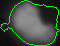

In [18]:
# Find cell outliers for the current plate
cell_outliers = find_outliers(
    df=filtered_plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        # Set low to attempt to detect all instances of abnormally high int in nuclei for whole cells
        "Cells_Intensity_IntegratedIntensity_CorrDNA": 0.5, 
    },
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
cell_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(cell_outliers),
    data_outline_context_dir=f"../2.feature_extraction/sqlite_outputs/{plate_id}/outlines",
    segmentation_file_regex=outline_to_orig_mapping,
)[
    [
        "Cells_Intensity_IntegratedIntensity_CorrDNA",
        "Image_FileName_OrigDNA",
    ]
]


print(cell_outliers_cdf.shape)
cell_outliers_cdf.sort_values(
    by="Cells_Intensity_IntegratedIntensity_CorrDNA", ascending=True
).head(2)

,Cells_Intensity_IntegratedIntensity_CorrDNA,Image_FileName_OrigDNA
63402,192.944633,
372428,231.436799,

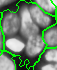
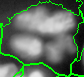

In [19]:
cell_outliers_cdf.sample(n=2, random_state=0)

## Save the outlier indices to use for reporting

In [20]:
# Identify failing indices from both outlier dataframes
outlier_indices = pd.concat(
    [nuclei_clustered_outliers, solidity_nuclei_outliers, cell_outliers]
).index.unique()

# Create a new dataframe with only the failing rows
failing_df = plate_df.loc[outlier_indices, metadata_columns].copy()

# Add failure condition columns, marking all rows as True for each condition they failed
failing_df["Failed_ClusteredNuclei"] = failing_df.index.isin(
    nuclei_clustered_outliers.index
)
failing_df["Failed_SolidityNuclei"] = failing_df.index.isin(
    solidity_nuclei_outliers.index
)
failing_df["Failed_CellsMultipleNuclei"] = failing_df.index.isin(
    cell_outliers.index
)

# Ensure boolean dtype
failing_df = failing_df.astype(
    {"Failed_ClusteredNuclei": bool, "Failed_SolidityNuclei": bool, "Failed_CellsMultipleNuclei": bool}
)

# Keep original indices for later
failing_df = failing_df.reset_index().rename(columns={"index": "original_indices"})

# Save the indices dataframe as CSV
failing_df.to_csv(
    pathlib.Path(f"{qc_results_dir}/{plate_id}_failed_qc_indices.csv.gz"),
    compression="gzip",
    index=False,
)

# Calculate percentage failed
total_rows = plate_df.shape[0]
failed_percentage = (failing_df.shape[0] / total_rows) * 100

# Print summary with percentage
print(f"Total failing single cells: {failing_df.shape[0]} ({failed_percentage:.2f}%)")

Total failing single cells: 64489 (13.85%)


## Clean and save the data

In [21]:
# Remove rows with outlier indices
plate_df_cleaned = plate_df.drop(outlier_indices)

# Save cleaned data for this plate
plate_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_id}_cleaned.parquet")

# Print the plate name and the shape of the cleaned data
print(
    f"{plate_id} has been cleaned and saved with the shape: {plate_df_cleaned.shape}."
)

BR00143978 has been cleaned and saved with the shape: (401251, 3035).
